### Training a Predictive Model
Now that we have the data appropriately formatted, we can use this data to train a Random Forest model.  First we need to import the necessary libraries. 

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from IPython.display import SVG

In [3]:
def fp_as_array(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [4]:
df = pd.read_csv("dude_erk1_mk01.csv")

In [5]:
df.head()

,Unnamed: 0,SMILES,ID,is_active
0,0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [6]:
print(df.is_active.value_counts())

0    4550
1      79
Name: is_active, dtype: int64


In [7]:
df['Mol'] = [Chem.MolFromSmiles(x) for x in df.SMILES]

In [8]:
fp_list = [fp_as_array(x) for x in df.Mol]

In [9]:
pred_list = []
mcc_list = []
for cycle in tqdm(range(0,10)):
    train_x, test_x, train_y, test_y = train_test_split(fp_list,df.is_active)
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(train_x,train_y)
    pred = rf.predict(test_x) 
    mcc_list.append(matthews_corrcoef(pred,test_y))

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


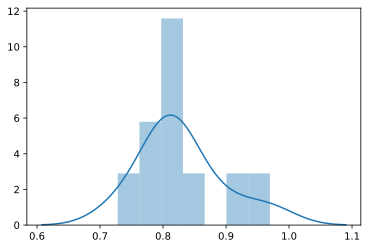

In [10]:
sns.distplot(mcc_list)

In [11]:
fp_list = [fp_as_array(x) for x in df.Mol]
fp_list = [([smiles,id],fp) for smiles,id,fp in zip(df.SMILES,df.ID,fp_list)]

In [12]:
pd.DataFrame(fp_list).head()

,0,1
0,[Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,[C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
rf = RandomForestClassifier(n_estimators=100)

In [14]:
mcc_list = []
detail_list = []
pred_list = []
for cycle in tqdm(range(0,10)):
    train_x, test_x, train_y, test_y = train_test_split(fp_list,df.is_active)
    train_name = [x[0] for x in train_x]
    train_fp = [x[1] for x in train_x]
    test_name = [x[0] for x in test_x]
    test_fp = [x[1] for x in test_x]
    rf.fit(train_fp,train_y)
    pred = rf.predict(test_fp) 
    pred_list.append([pred,test_y])
    for name, pred_val, true_val in zip(test_name,pred,test_y):
        detail_list.append([cycle,name,pred_val,true_val])
    mcc_list.append(matthews_corrcoef(pred,test_y))

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [15]:
row_list = []
for p,t in pred_list:
    row_list.append(confusion_matrix(p,t).flatten())
confusion_df = pd.DataFrame(row_list,columns="tn,fn,fp,tp".split(","))
confusion_df

,tn,fn,fp,tp
0,1141,5,0,12
1,1140,7,0,11
2,1139,3,0,16
3,1142,4,0,12
4,1142,8,0,8
5,1143,5,0,10
6,1138,6,0,14
7,1144,3,0,11
8,1135,8,0,15
9,1130,9,0,19


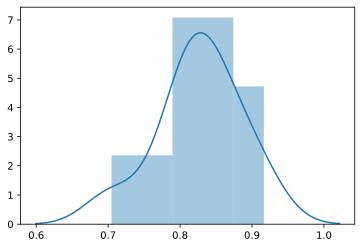

In [16]:
sns.distplot(mcc_list)

In [17]:
detail_df = pd.DataFrame(detail_list,columns=["cycle","smi_list","pred","true"])

In [18]:
detail_df.query("cycle == 0").pred.value_counts()

0    1146
1      12
Name: pred, dtype: int64

In [19]:
fn_smiles = [x[0] for x in detail_df.query("pred == 0 and true == 1 and cycle == 0").smi_list]
len(fn_smiles)

5

In [20]:
from rdkit.Chem.Draw import MolsToGridImage

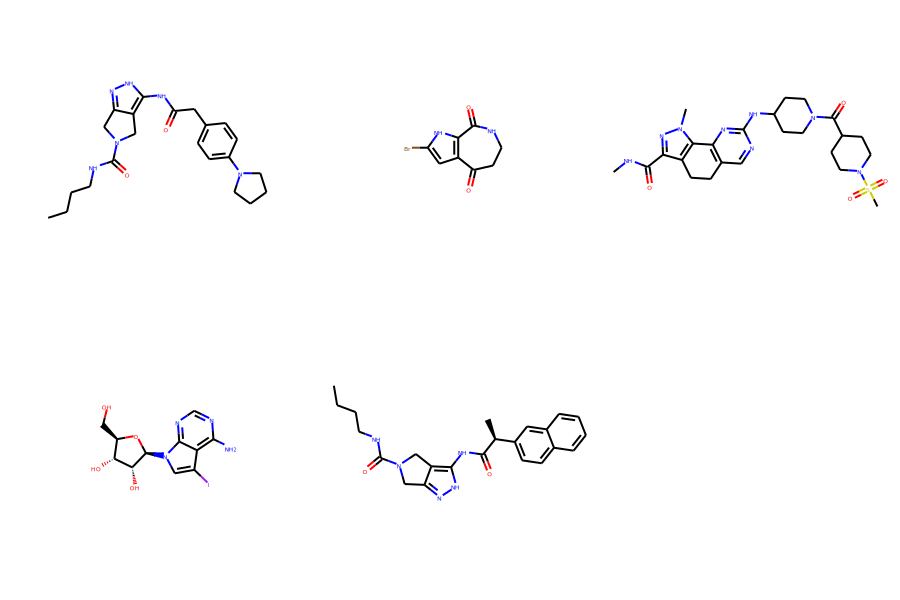

In [21]:
svg = MolsToGridImage([Chem.MolFromSmiles(x) for x in fn_smiles],molsPerRow=3,useSVG=True,subImgSize=(300, 300))
SVG(svg)

In [22]:
model = RandomForestClassifier(n_estimators=100)

In [23]:
model.fit([x[1] for x in fp_list],df.is_active)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
!pip install joblib

In [25]:
from joblib import dump, load
dump(model, 'mk01_model.joblib') 

['mk01_model.joblib']

In [26]:
avail_df = pd.read_csv("mk01/zinc_100k.smi",sep=" ",header=None)
avail_df.columns = ["SMILES","Name"]

In [27]:
avail_df.head()

,SMILES,Name
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101


In [28]:
mol_list = [Chem.MolFromSmiles(x) for x in avail_df.SMILES]

In [29]:
avail_fp_list = [fp_as_array(x) for x in mol_list]

In [30]:
avail_pred = model.predict(avail_fp_list)

In [33]:
sum(avail_pred)

0

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
lr = LogisticRegression(solver='lbfgs')

In [37]:
lr.fit([x[1] for x in fp_list],df.is_active)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
lr_pred = lr.predict(avail_fp_list)

In [39]:
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
sum(lr_pred)

19

In [41]:
avail_df['LR'] = lr_pred

In [42]:
avail_df.head()

,SMILES,Name,LR
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,0
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,0
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,0
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0


In [43]:
avail_df.LR.value_counts()

0    99981
1       19
Name: LR, dtype: int64

In [44]:
avail_active = avail_df.query("LR == 1").copy()

In [45]:
avail_active.shape

(19, 3)

In [46]:
from rdkit.Chem import PandasTools

In [47]:
PandasTools.AddMoleculeColumnToFrame(avail_active,smilesCol="SMILES")

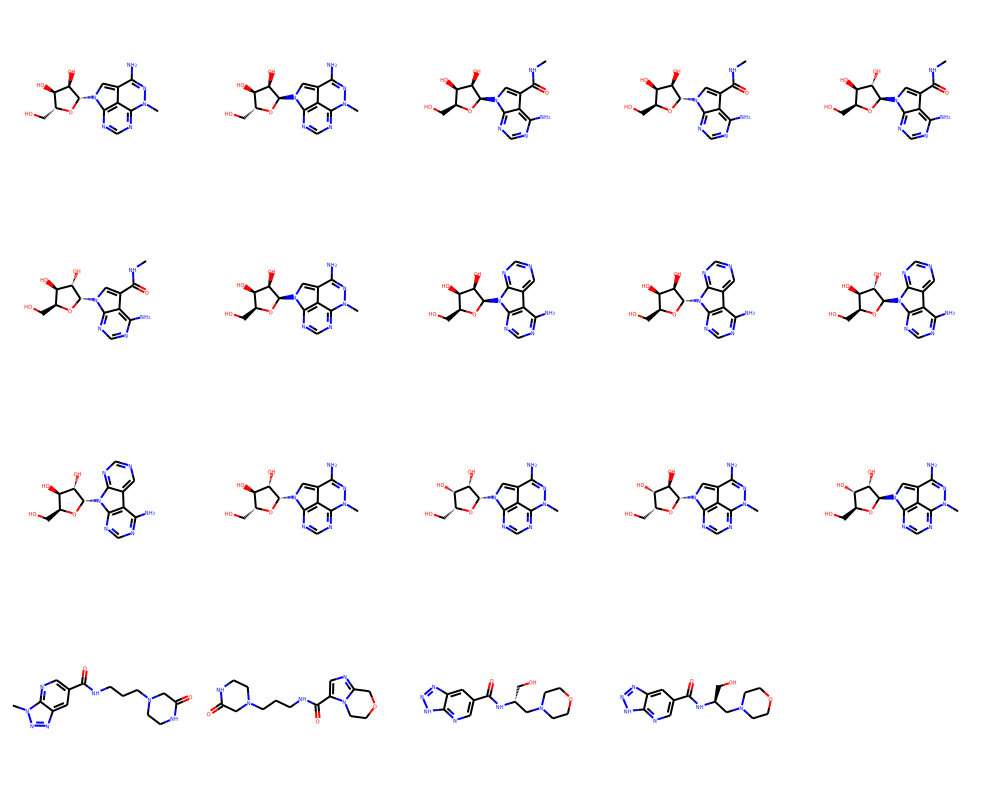

In [48]:
pic = MolsToGridImage([x for x in avail_active.ROMol],molsPerRow=5,useSVG=True)
SVG(pic)